#**🌟Super Resolution Image Generate💫**

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
div2k_data = tfds.image.Div2k(config="bicubic_x4")
div2k_data.download_and_prepare()

train = div2k_data.as_dataset(split = "train", as_supervised = True)
train_data = train.cache()

val = div2k_data.as_dataset(split = "validation", as_supervised = True)
val_data = val.cache()

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteNI18ES/div2k-train.tfrecord*...:   0%|   …

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteNI18ES/div2k-validation.tfrecord*...:   0…

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


In [3]:
def flip_left_right(lowres_img, highres_img):
    """Flips Images to left and right."""

    # Outputs random values from a uniform distribution in between 0 to 1
    rn = tf.random.uniform(shape=(), maxval=1)
    # If rn is less than 0.5 it returns original lowres_img and highres_img
    # If rn is greater than 0.5 it returns flipped image
    return tf.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            tf.image.flip_left_right(lowres_img),
            tf.image.flip_left_right(highres_img),
        ),
    )


def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    # Outputs random values from uniform distribution in between 0 to 4
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    # Here rn signifies number of times the image(s) are rotated by 90 degrees
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)


def random_crop(lowres_img, highres_img, hr_crop_size=96, scale=4):
    """Crop images.

    low resolution images: 24x24
    high resolution images: 96x96
    """
    lowres_crop_size = hr_crop_size // scale  # 96//4=24
    lowres_img_shape = tf.shape(lowres_img)[:2]  # (height,width)

    lowres_width = tf.random.uniform(shape=(), maxval=lowres_img_shape[1] - lowres_crop_size + 1, dtype=tf.int32)
    lowres_height = tf.random.uniform(shape=(), maxval=lowres_img_shape[0] - lowres_crop_size + 1, dtype=tf.int32)

    highres_width = lowres_width * scale
    highres_height = lowres_height * scale

    lowres_img_cropped = lowres_img[
        lowres_height : lowres_height + lowres_crop_size,
        lowres_width : lowres_width + lowres_crop_size,
    ]  # 24x24
    highres_img_cropped = highres_img[
        highres_height : highres_height + hr_crop_size,
        highres_width : highres_width + hr_crop_size,
    ]  # 96x96

    return lowres_img_cropped, highres_img_cropped

In [4]:
def get_dataset(dataset, training = True):
    dataset = dataset.map(lambda lower, higher : random_crop(lower, higher), num_parallel_calls = tf.data.AUTOTUNE)

    if training:
        dataset = dataset.map(random_rotate, num_parallel_calls = tf.data.AUTOTUNE)
        dataset = dataset.map(flip_left_right, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.batch(16)

    if training:
        dataset = dataset.repeat()
    dataset = dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

    return dataset

In [5]:
train_dataset = get_dataset(train_data)
valid_dataset = get_dataset(val_data, training = False)

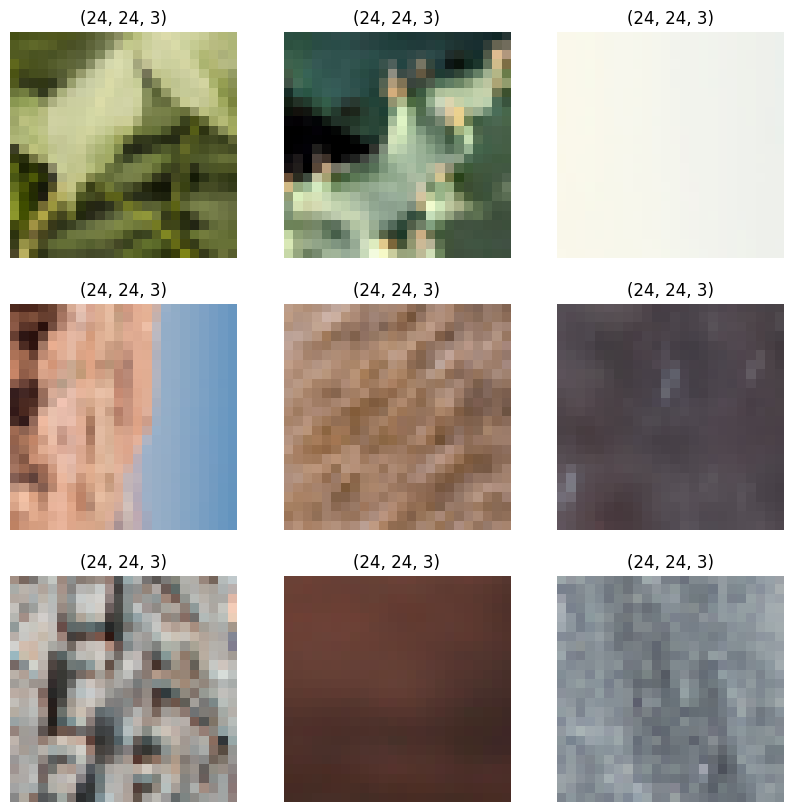

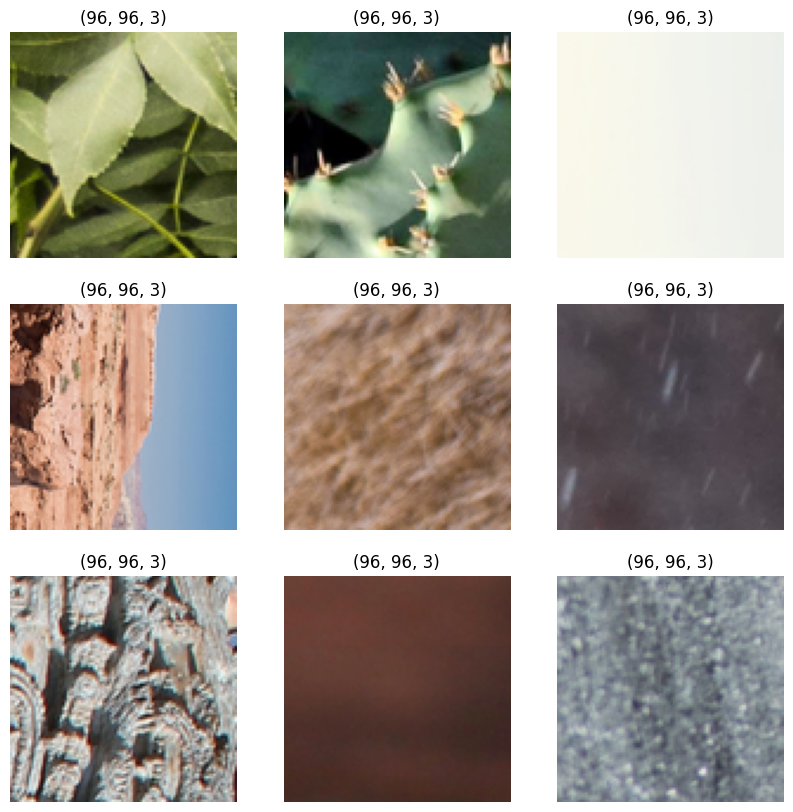

In [6]:
lower, higher = next(iter(train_dataset))

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(lower[i].numpy().astype("uint8"))
    plt.title(lower[i].shape)
    plt.axis("off")



plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(higher[i].numpy().astype("uint8"))
    plt.title(higher[i].shape)
    plt.axis("off")

## Build the model

In the paper, the authors train three models: EDSR, MDSR, and a baseline model. In this code example,
we only train the baseline model.

### Comparison with model with three residual blocks

The residual block design of EDSR differs from that of ResNet. Batch normalization
layers have been removed (together with the final ReLU activation): since batch normalization
layers normalize the features, they hurt output value range flexibility.
It is thus better to remove them. Further, it also helps reduce the
amount of GPU RAM required by the model, since the batch normalization layers consume the same amount of
memory as the preceding convolutional layers.

<img src="https://miro.medium.com/max/1050/1*EPviXGqlGWotVtV2gqVvNg.png" width="500" />

In [7]:
class EDSRModel(keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, x):
        # Adding dummy dimension using tf.expand_dims and converting to float32 using tf.cast
        x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
        # Passing low resolution image to model
        super_resolution_img = self(x, training=False)
        # Clips the tensor from min(0) to max(255)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)
        # Rounds the values of a tensor to the nearest integer
        super_resolution_img = tf.round(super_resolution_img)
        # Removes dimensions of size 1 from the shape of a tensor and converting to uint8
        super_resolution_img = tf.squeeze(
            tf.cast(super_resolution_img, tf.uint8), axis=0
        )
        return super_resolution_img

In [8]:
def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding = "same", activation = "relu")(inputs)
    x = layers.Conv2D(64, 3, padding = "same")(x)
    x = layers.Add()([inputs, x])
    return x


def Upsample_block(inputs, factor = 2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding = "same", **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size = factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding = "same", **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size = factor)
    return x

def build_model(n_filters, n_resblock):
    inputs = keras.Input(shape = (None, None, 3))
    x = layers.Rescaling(1.0 / 255.0)(inputs)

    x = x_new = layers.Conv2D(n_filters, 3, padding = "same")(x)

    for _ in range(n_resblock):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(n_filters, 3, padding = "same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsample_block(x)
    x = layers.Conv2D(3, 3, padding = "same")(x)
    outputs = layers.Rescaling(255)(x)
    return EDSRModel(inputs, outputs)

model = build_model(n_filters = 64, n_resblock = 16)

Compute the peak signal-to-noise ratio, measures quality of image.

In [9]:
def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value

In [10]:
#Using adam optimizer with initial learning rate as 1e-4, changing learning rate after 5000 steps to 5e-5

lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5])

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = lr_schedule),
    loss  = "mae", # Use L1 loss
    metrics = [PSNR])

In [11]:
model.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs = 100,
    steps_per_epoch = 200)

Epoch 1/100
200/200 [==============================] - 94s 335ms/step - loss: 29.4875 - PSNR: 18.7244 - val_loss: 14.0213 - val_PSNR: 23.1964
Epoch 2/100
200/200 [==============================] - 7s 36ms/step - loss: 13.5735 - PSNR: 24.1009 - val_loss: 11.9990 - val_PSNR: 23.4105
Epoch 3/100
200/200 [==============================] - 7s 34ms/step - loss: 11.5516 - PSNR: 26.0885 - val_loss: 9.9886 - val_PSNR: 27.6351
Epoch 4/100
200/200 [==============================] - 7s 36ms/step - loss: 10.2627 - PSNR: 27.3411 - val_loss: 10.0100 - val_PSNR: 26.6420
Epoch 5/100
200/200 [==============================] - 7s 35ms/step - loss: 9.6234 - PSNR: 27.6567 - val_loss: 9.2977 - val_PSNR: 27.2489
Epoch 6/100
200/200 [==============================] - 7s 36ms/step - loss: 9.4078 - PSNR: 28.5041 - val_loss: 9.1067 - val_PSNR: 28.1013
Epoch 7/100
200/200 [==============================] - 7s 37ms/step - loss: 8.9419 - PSNR: 28.7716 - val_loss: 9.0181 - val_PSNR: 28.1594
Epoch 8/100
200/200 [====

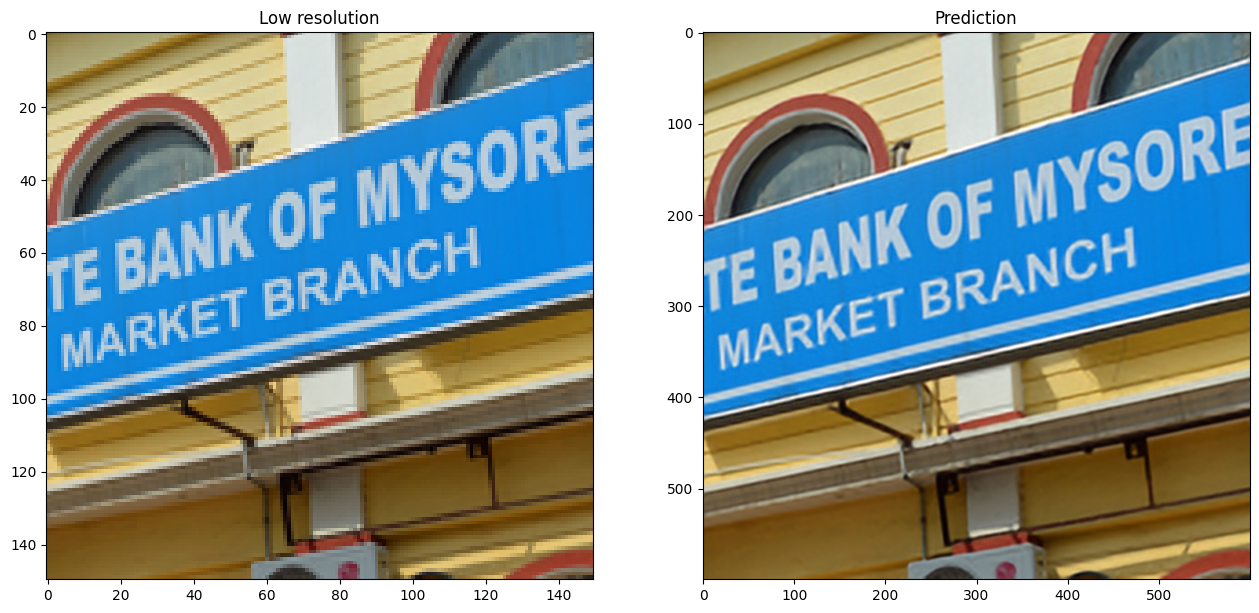

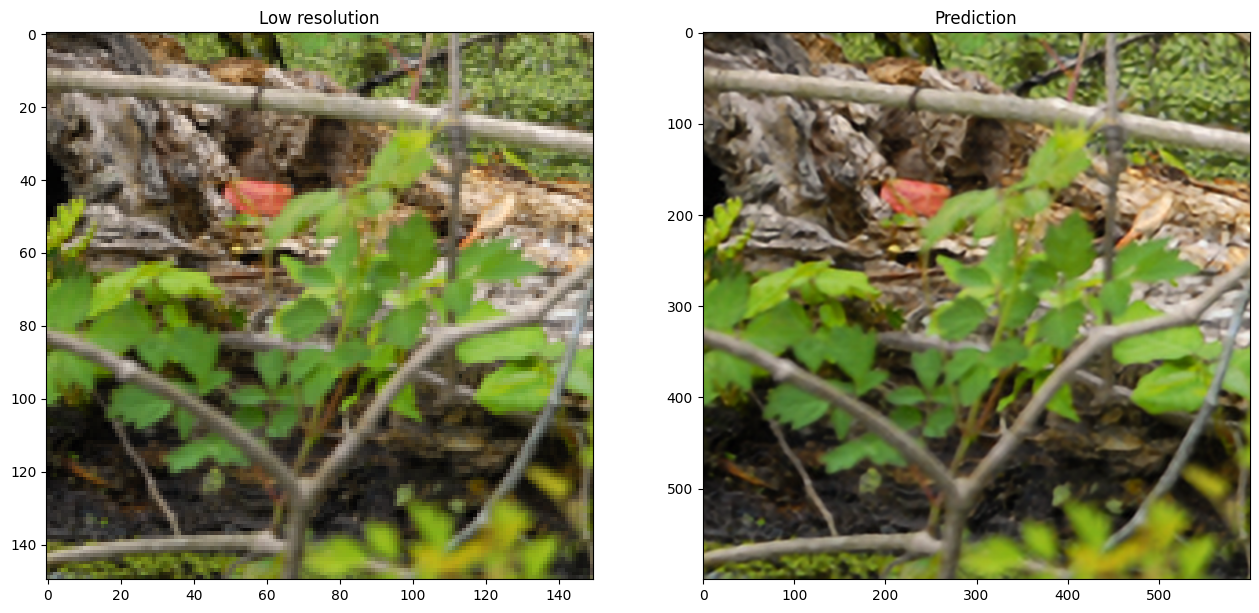

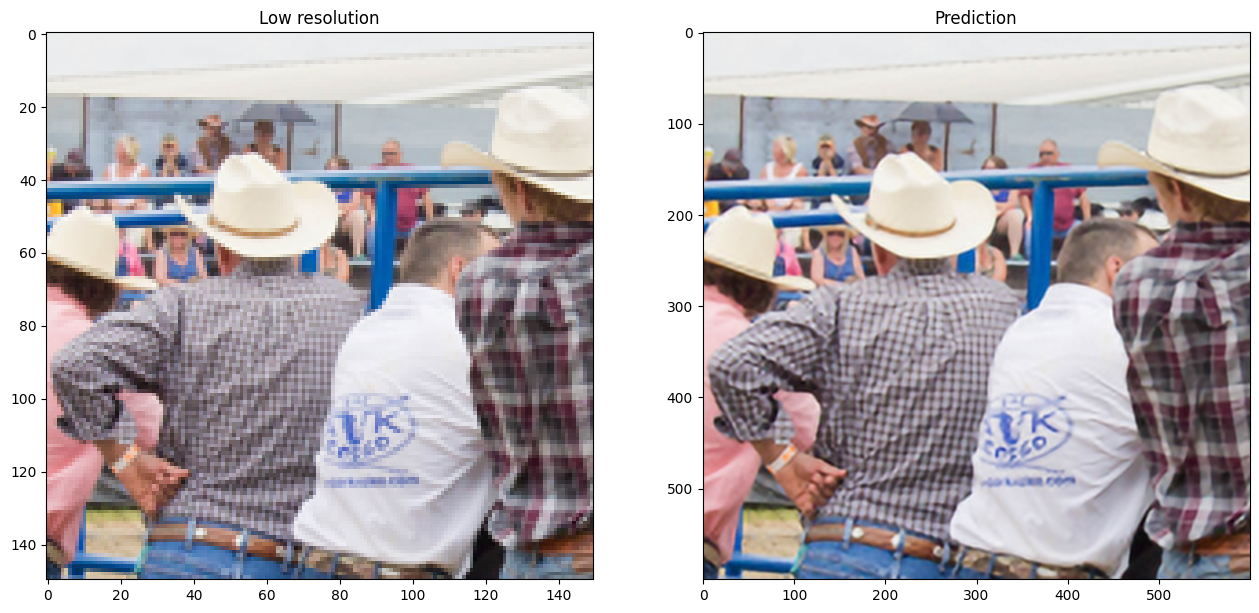

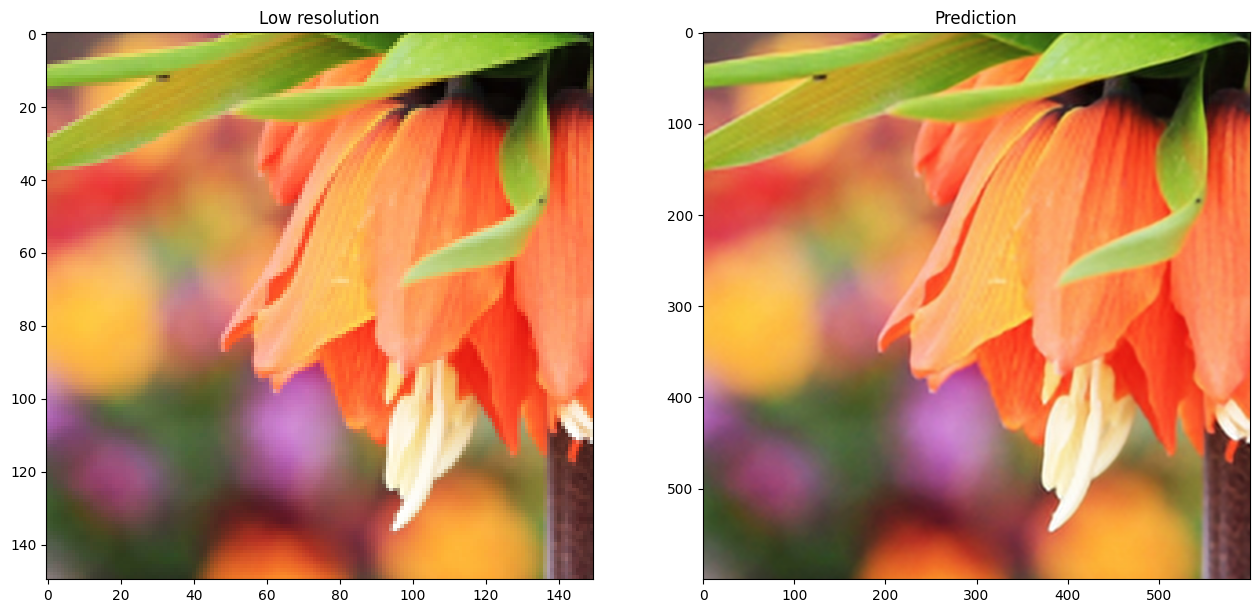

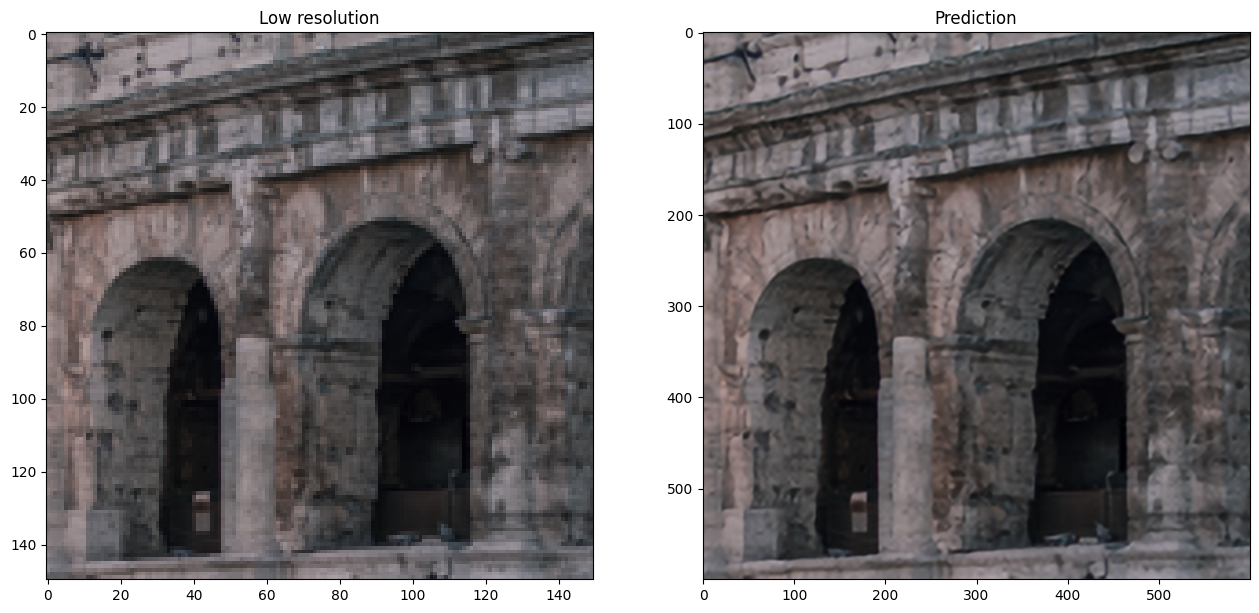

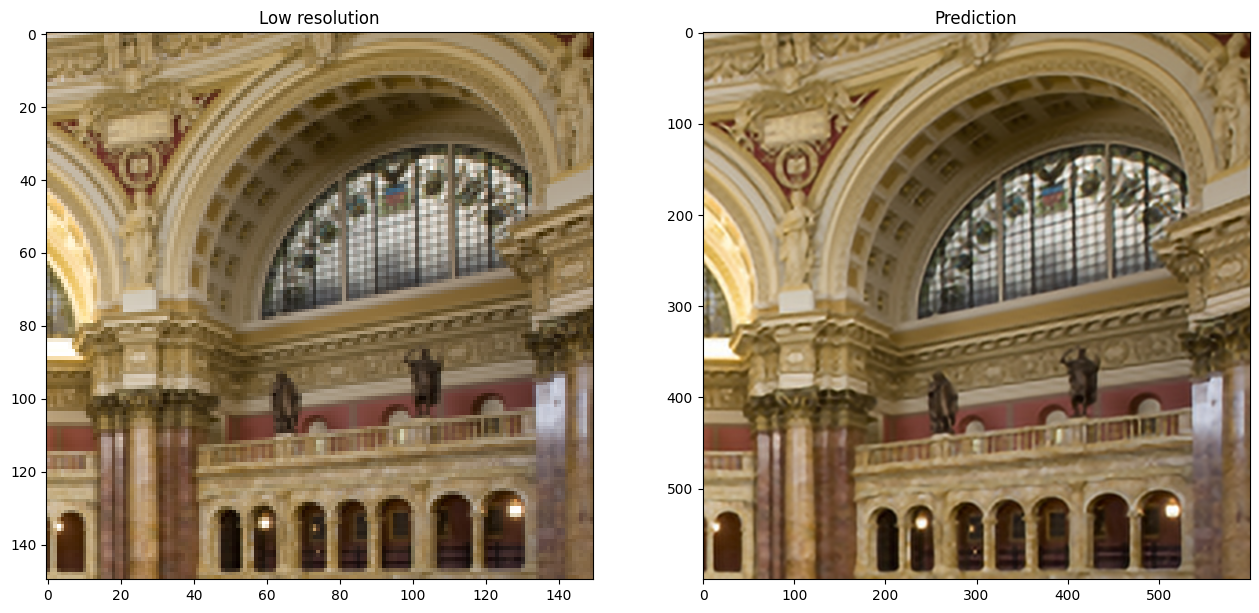

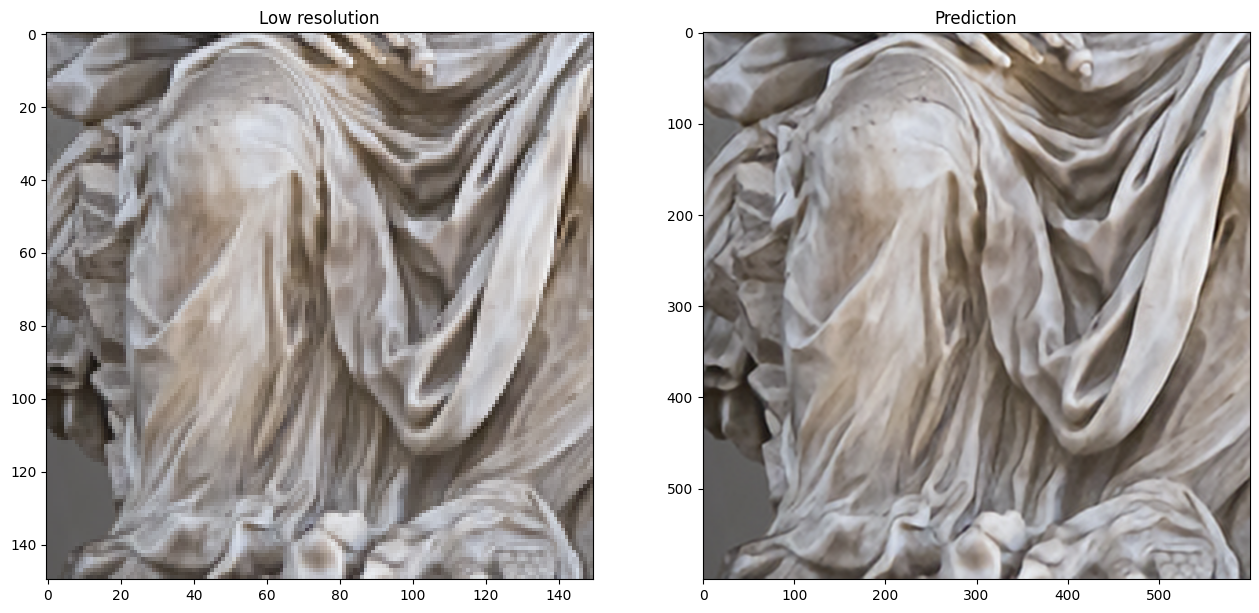

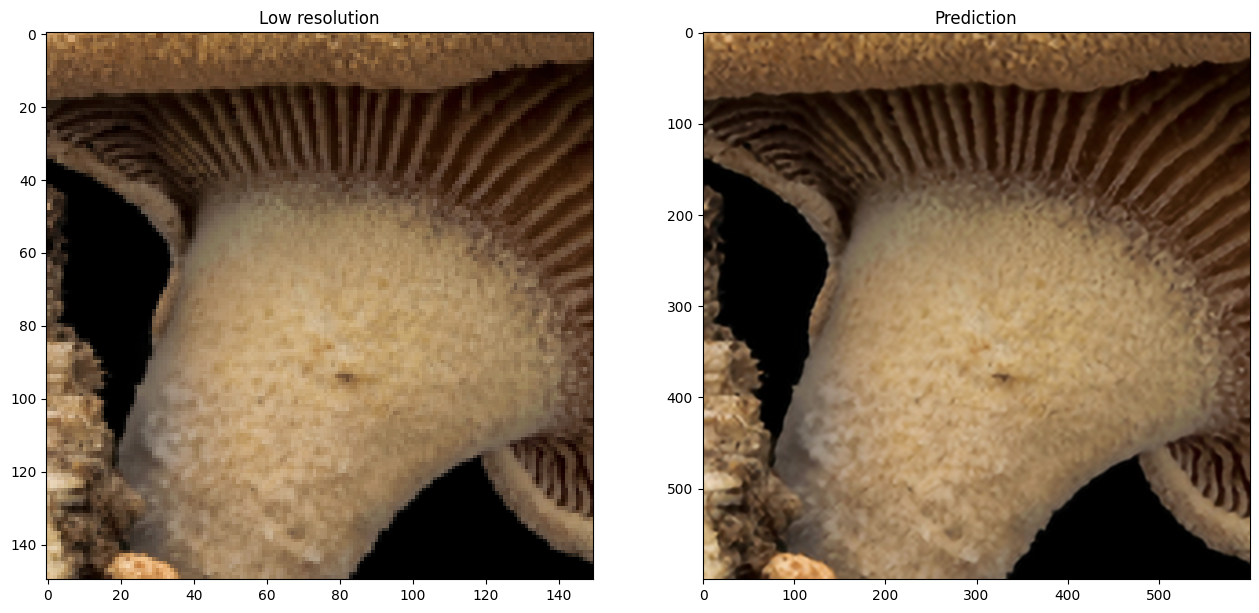

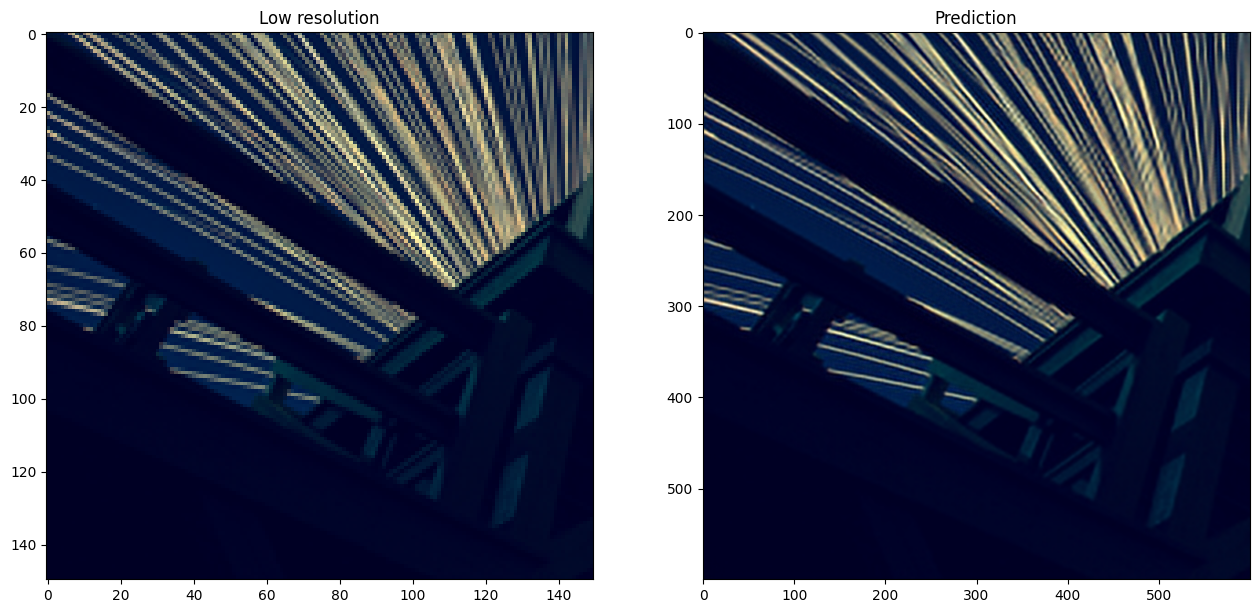

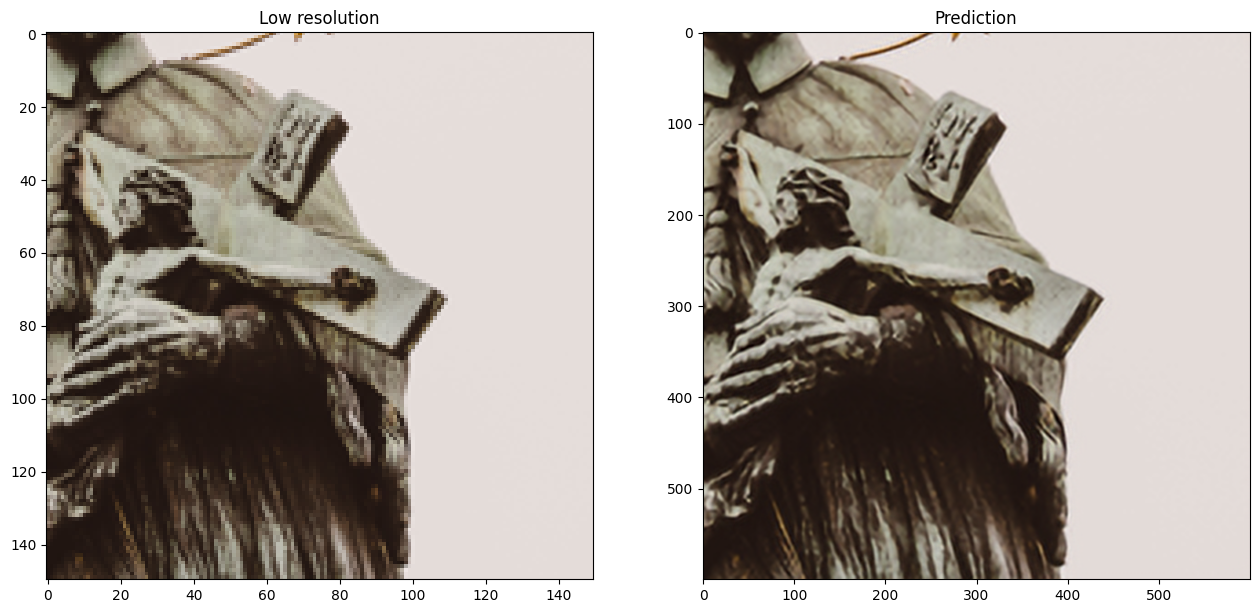

In [18]:
def plot_predictions(lower, pred):

    plt.figure(figsize=(24, 14))
    plt.subplot(132)
    plt.imshow(lower)
    plt.title("Low resolution")

    plt.subplot(133)
    plt.imshow(pred)
    plt.title("Prediction")
    plt.show()

for lower, _ in val.take(10):
    lower = tf.image.random_crop(lower, (150, 150, 3))
    pred = model.predict_step(lower)
    plot_predictions(lower, pred)